## Setup and Imports

In [1]:
import math
import keras
import keras_cv
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

2023-07-06 05:01:37.276937: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 05:01:37.753193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops

## Dataset

In [2]:
# Dataset hyperparameters
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
NUM_CLASSES = 10

# Algorithm hyperparameter
UNLABELED_BATCH_SIZE = 1024
LABELED_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
WIDTH = 128
TEMPERATURE = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
CONTRASTIVE_AUGMENTATION = {
    "min_area": 0.25,
    "brightness": keras_cv.UniformFactorSampler(lower=-0.6, upper=0.6),
    "jitter": keras_cv.UniformFactorSampler(lower=-0.2, upper=0.2),
}
CLASSIFICATION_AUGMENTATION = {
    "min_area": 0.75,
    "brightness": keras_cv.UniformFactorSampler(lower=-0.3, upper=0.3),
    "jitter": keras_cv.UniformFactorSampler(lower=-0.1, upper=0.1),
}

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def prepare_dataset():
    unlabeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="unlabelled", as_supervised=True)
        .map(lambda image, label: image, num_parallel_calls=AUTOTUNE)
        .shuffle(buffer_size=2 * UNLABELED_BATCH_SIZE)
        .batch(UNLABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    labeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="train", as_supervised=True)
        .shuffle(buffer_size=10 * LABELED_BATCH_SIZE)
        .batch(LABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    test_dataset = (
        tfds.load("stl10", data_dir="dataset", split="test", as_supervised=True)
        .batch(TEST_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    return unlabeled_train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
unlabeled_train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

2023-07-06 05:02:12.854536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38169 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


## Augmentation Pipeline

In [4]:
# Distorts the color distibutions of images
class RandomColorAffine(keras_cv.layers.BaseImageAugmentationLayer):
    def __init__(self, brightness, jitter, **kwargs):
        super().__init__(**kwargs)
        self.brightness = brightness
        self.jitter = jitter

    def augment_image(self, image, transformation=None, **kwargs):
        # Same for all colors
        brightness_scales = 1 + self.brightness(shape=(1, 1, 1))

        # Different for all colors
        jitter_matrices = self.jitter(shape=(1, 3, 3))

        color_transforms = (
            tf.eye(num_rows=3) * brightness_scales + jitter_matrices
        )
        image = tf.clip_by_value(tf.matmul(image, color_transforms), 0, 1)

        return image

In [5]:
# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
            keras_cv.layers.Rescaling(scale=1./255),
            keras_cv.layers.RandomFlip("horizontal"),
            keras_cv.layers.RandomTranslation(
                height_factor=zoom_factor/2,
                width_factor=zoom_factor/2,

            ),
            keras_cv.layers.RandomZoom(
                height_factor=(-zoom_factor, 0.0),
                width_factor=(-zoom_factor, 0.0),
            ),
            RandomColorAffine(brightness, jitter),
        ]
    )

2023-07-06 05:02:28.976809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-07-06 05:02:28.977398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]


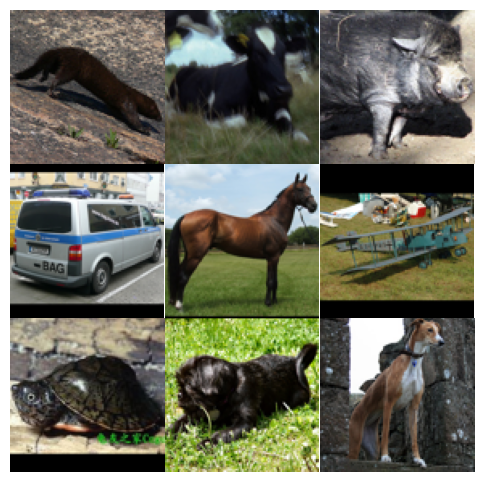

In [6]:
# Original Images
unlabeled_images = next(iter(unlabeled_train_dataset))
keras_cv.visualization.plot_image_gallery(
    images=unlabeled_images,
    value_range=(0, 255),
    rows=3,
    cols=3,
)

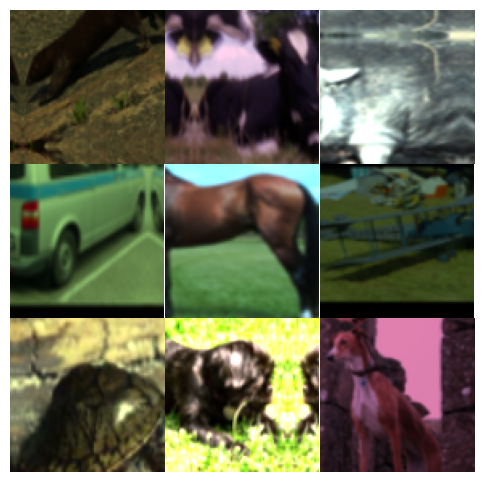

In [7]:
# Contrastive Augmentations
contrastive_augmenter = get_augmenter(**CONTRASTIVE_AUGMENTATION)
augmented_images = contrastive_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

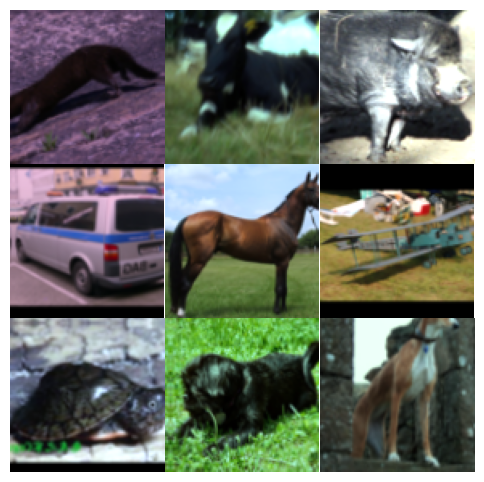

In [8]:
# Classification Augmentations
classification_augmenter = get_augmenter(**CLASSIFICATION_AUGMENTATION)
augmented_images = classification_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

## Encoder

In [9]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        keras_cv.models.ResNet18Backbone(include_rescaling=False),
        keras.layers.GlobalAveragePooling2D(name="avg_pool"),
    ],
        name="encoder",
)

## Supervised Baseline Model

In [10]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        get_encoder(),
        keras.layers.Dense(NUM_CLASSES),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


2023-07-06 05:02:50.785133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-06 05:02:50.785652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-06 05:02:54.448871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-06 05:02:57.214468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - ETA: 0s - loss: 1.9383 - acc: 0.3190

2023-07-06 05:02:59.808705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2023-07-06 05:02:59.809188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]


40/40 [==============================] - 11s 91ms/step - loss: 1.9383 - acc: 0.3190 - val_loss: 3.5300 - val_acc: 0.1671
Epoch 2/20
40/40 [==============================] - 2s 47ms/step - loss: 1.5939 - acc: 0.4142 - val_loss: 5.8598 - val_acc: 0.1000
Epoch 3/20
40/40 [==============================] - 2s 40ms/step - loss: 1.4446 - acc: 0.4572 - val_loss: 6.2005 - val_acc: 0.1039
Epoch 4/20
40/40 [==============================] - 2s 41ms/step - loss: 1.3940 - acc: 0.4800 - val_loss: 2.6265 - val_acc: 0.1801
Epoch 5/20
40/40 [==============================] - 2s 47ms/step - loss: 1.3269 - acc: 0.5142 - val_loss: 3.7527 - val_acc: 0.1445
Epoch 6/20
40/40 [==============================] - 2s 40ms/step - loss: 1.2015 - acc: 0.5602 - val_loss: 3.0223 - val_acc: 0.2251
Epoch 7/20
40/40 [==============================] - 2s 40ms/step - loss: 1.2401 - acc: 0.5430 - val_loss: 2.9168 - val_acc: 0.1615
Epoch 8/20
40/40 [==============================] - 2s 42ms/step - loss: 1.1801 - acc: 0.5624

## Self-supervised model for contrastive pretraining

In [11]:
class SimCLRTrainer(keras_cv.training.ContrastiveTrainer):
    def __init__(self, encoder, augmenter, projector, probe=None, **kwargs):
        super().__init__(
            encoder=encoder,
            augmenter=augmenter,
            projector=projector,
            probe=probe,
            **kwargs,
        )

In [13]:
simclr_model = SimCLRTrainer(
    encoder=get_encoder(),
    augmenter=get_augmenter(**CONTRASTIVE_AUGMENTATION),
    projector=keras.Sequential(
        [
            keras.layers.Dense(WIDTH, activation="relu"),
            keras.layers.Dense(WIDTH),
            keras.layers.BatchNormalization(),
        ],
        name="projector",
    ),
)

simclr_model.compile(
    encoder_optimizer=keras.optimizers.Adam(),
    encoder_loss=keras_cv.losses.SimCLRLoss(
        temperature=TEMPERATURE,
    ),
)

In [14]:
simclr_history = simclr_model.fit(
    unlabeled_train_dataset,
    epochs=50,
)

2023-07-06 05:05:03.092901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype resource
	 [[{{node Placeholder/_33}}]]
2023-07-06 05:05:03.093559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype resource
	 [[{{node Placeholder/_33}}]]


Epoch 1/50
98/98 [==============================] - 68s 587ms/step - loss: 10.9895
Epoch 2/50
98/98 [==============================] - 62s 596ms/step - loss: 7.0992
Epoch 3/50
98/98 [==============================] - 62s 599ms/step - loss: 5.8184
Epoch 4/50
98/98 [==============================] - 62s 598ms/step - loss: 5.1063
Epoch 5/50
98/98 [==============================] - 62s 597ms/step - loss: 4.6526
Epoch 6/50
98/98 [==============================] - 62s 597ms/step - loss: 4.3464
Epoch 7/50
98/98 [==============================] - 62s 595ms/step - loss: 4.0785
Epoch 8/50
98/98 [==============================] - 62s 596ms/step - loss: 3.8390
Epoch 9/50
98/98 [==============================] - 61s 596ms/step - loss: 3.6753
Epoch 10/50
98/98 [==============================] - 62s 597ms/step - loss: 3.5110
Epoch 11/50
98/98 [==============================] - 62s 597ms/step - loss: 3.4046
Epoch 12/50
98/98 [==============================] - 62s 594ms/step - loss: 3.2487
Epoch 13/50


## Fine tuning

In [19]:
# Supervised finetuning of the pretrained encoder
finetune_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        simclr_model.encoder,
        keras.layers.Dense(NUM_CLASSES),
    ],
    name="finetuning_model",
)
finetune_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

In [ ]:
finetune_history = finetune_model.fit(
    labeled_train_dataset, epochs=20, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetune_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
40/40 [==============================] - 6s 66ms/step - loss: 1.2020 - acc: 0.5792 - val_loss: 7.0288 - val_acc: 0.2319
Epoch 2/20
40/40 [==============================] - 2s 39ms/step - loss: 0.8235 - acc: 0.7060 - val_loss: 2.8955 - val_acc: 0.3020
Epoch 3/20
40/40 [==============================] - 2s 47ms/step - loss: 0.7429 - acc: 0.7316 - val_loss: 1.6027 - val_acc: 0.5344
Epoch 4/20
40/40 [==============================] - 2s 40ms/step - loss: 0.6562 - acc: 0.7548 - val_loss: 2.0665 - val_acc: 0.4597
Epoch 5/20
40/40 [==============================] - 2s 40ms/step - loss: 0.6226 - acc: 0.7776 - val_loss: 1.4241 - val_acc: 0.5415
Epoch 6/20
40/40 [==============================] - 2s 43ms/step - loss: 0.5356 - acc: 0.8110 - val_loss: 1.3258 - val_acc: 0.5710
Epoch 7/20
40/40 [==============================] - 2s 41ms/step - loss: 0.4820 - acc: 0.8276 - val_loss: 1.0963 - val_acc: 0.6202
Epoch 8/20
40/40 [==============================] - 2s 39ms/step - loss: 0.4104 - a

# Visualization

In [ ]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(baseline_history, finetune_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"],
            label="supervised baseline"
        )
        plt.plot(
            finetune_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(baseline_history, finetune_history)